## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [3]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P /mnt/c/Users/chiara/LaboratoryOfComputationalPhysics_Y3/data/

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/chiara/.wget-hsts'. HSTS will be disabled.
--2020-12-09 14:39:52--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6025:1::a27d:4501, 162.125.69.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6025:1::a27d:4501|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2020-12-09 14:39:53--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc616aedcb63da5b499acb6641c3.dl.dropboxusercontent.com/cd/0/inline/BEsD1AKNEJbwP-vhX212WXb4Fo3_O6U_Z7HV-qpQoIPd70AzsbGpq-6R1GGx3qRAe8oMNzdJmeKl0p1gSpLtkXP880CA_Gby5PenOJWPGegAsa7IvJKrvGT5xJDW1j5ouiI/file# [following]
--2020-12-09 1

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
#1

import pandas as pd
import numpy as np


n=200000
file="/mnt/c/Users/chiara/LaboratoryOfComputationalPhysics_Y3/data/data_000637.txt"
data=pd.read_csv(file,nrows=n)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0
199996,1,0,62,3869202157,76,2
199997,1,1,2,3869202157,94,15
199998,1,1,1,3869202157,96,13


In [3]:
#2
a=data.BX_COUNTER.max()

conv=a*25
print(conv)

89075


In [4]:
#3
time0=data.loc[0,'TDC_MEAS']*25/30+data.loc[0,'BX_COUNTER']*25+data.loc[0,'ORBIT_CNT']*conv
timeN=data.loc[(n-1),'TDC_MEAS']*25/30+data.loc[(n-1),'BX_COUNTER']*25+data.loc[(n-1),'ORBIT_CNT']*conv

print("Duration of data taking: ", (timeN-time0)*10**(-9), " s" )

Duration of data taking:  0.17720256912500001  s


In [41]:
#4

data['timens']=data['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*conv-time0
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0,1.772018e+08
199996,1,0,62,3869202157,76,2,1.772018e+08
199997,1,1,2,3869202157,94,15,1.772022e+08
199998,1,1,1,3869202157,96,13,1.772023e+08


In [5]:
#5
for i in range(n):
    data.loc[i,'HEAD']=np.random.randint(0,2)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,0,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,0,0,64,3869200167,2760,25
...,...,...,...,...,...,...
199995,0,0,139,3869202157,76,0
199996,1,0,62,3869202157,76,2
199997,0,1,2,3869202157,94,15
199998,0,1,1,3869202157,96,13


In [6]:
#6 
df=data[data['HEAD']==1]
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
3,1,0,64,3869200167,2558,19
5,1,0,63,3869200167,2762,4
7,1,0,139,3869200167,2776,0
...,...,...,...,...,...,...
199991,1,0,74,3869202157,41,11
199992,1,0,64,3869202157,61,24
199993,1,0,63,3869202157,62,2
199996,1,0,62,3869202157,76,2


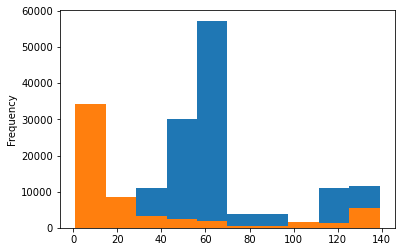

In [7]:
#7
fpga0=data[data['FPGA']==0]
fpga1=data[data['FPGA']==1]

fpga0

tdc0= fpga0.loc[:, 'TDC_CHANNEL']
tdc0.plot.hist()
tdc1= fpga1.loc[:, 'TDC_CHANNEL']
tdc1.plot.hist()

In [8]:
#8 
a=data.groupby('TDC_CHANNEL').count().sort_values('HEAD', ascending=False)
print(a.head(3))

              HEAD   FPGA  ORBIT_CNT  BX_COUNTER  TDC_MEAS
TDC_CHANNEL                                               
139          16627  16627      16627       16627     16627
64            9910   9910       9910        9910      9910
63            9684   9684       9684        9684      9684


In [9]:
#9
x1=pd.unique(data['ORBIT_CNT'])
print('Number of unique orbits:', len(x1))
dataframe=data[data['TDC_CHANNEL']==139]
x2=pd.unique(dataframe['ORBIT_CNT'])
print("Number of unique orbits with TDC_CHANNEL=139: ", len(x2))

Number of unique orbits: 1989
Number of unique orbits with TDC_CHANNEL=139:  1987
